# 3. Hands-on experiment:  Computing a geometric embedding for the Sparsest Cut Problem via Semidefinite Programming (20 pts)


The Uniform Sparsest Cut problem (USC) aims to find a bipartition $(S, \bar{S})$ of the nodes of a graph $G = (V, E)$, $\vert V \vert = p$, which minimizes the quantity 
\begin{equation*}
\label{sceq}
       \frac{E(S, \bar{S})}{\lvert S \rvert \; \lvert \bar{S} \rvert}, 
\end{equation*}
where $E(S, \bar{S})$ is the number of edges connecting $S$ and $\bar{S}$, and $\lvert S \rvert $ is the number of nodes in $S$.

Computing such a bipartition is NP-hard and intense research has gone into designing efficient approximation algorithms for this problem. In the seminal work of Arora, Rao and Vazirani (2009), an $\mathcal{O}(\sqrt{\log p})$ approximation algorithm is proposed for solving USC, which relies on finding a well-spread $\ell_2^2$ geometric representation of $G$ where each node $i\in V$ is mapped to a vector $\mathbf{v}_i$ in $\mathbb{R}^p$. In this experimental section we focus on solving the SDP that computes this geometric embedding. 

### SDP formulation
The canonical formulation of the SDP is
\begin{align}
\mathbf{X}^\star \in \arg \min_{ \mathbf{X} } \bigg\{ \langle \boldsymbol{C}, \mathbf{X} \rangle : &~p \; \mathrm{Tr}(\mathbf{X}) -  \mathrm{Tr}(\mathbf{1}_{p\times p}\mathbf{X}) = \frac{p^2}{2}, \\\\ 
& \; \mathbf{X}_{i,j} + \mathbf{X}_{j,k} - \mathbf{X}_{i, k} - \mathbf{X}_{j,j} \leq 0, \; \forall\ i \neq j \neq k \neq i\in V, \\\\
&~\underbrace{\mathrm{Tr}(\mathbf{X}) \leq p, ~\mathbf{X} \in \mathbb{R}^{p\times p} ,~\mathbf{X}\succeq 0}_{\mathcal{X}} \bigg\},
\end{align}
where $\boldsymbol{C}$ represents the Laplacian of graph $G$ and $\mathbf{X}_{i,j} = \langle \mathbf{v}_{i}, \mathbf{v}_j\rangle$ gives the geometric embedding of the nodes. We can rewrite the above SDP as


\begin{equation}
    \label{eq:reform-sdp}
    \min_{\mathbf{X} \in \mathcal{X}} f(\mathbf{X}) + g(A(\mathbf{X})) ~~~~~~~~\text{ subject to } ~~~~B_{i,j,k}(\mathbf{X}) \in \mathcal{K}, \;\forall\ i \neq j \neq k \neq i\in V,
\end{equation}
where $f(\mathbf{X}) = \langle \boldsymbol{C}, \mathbf{X} \rangle$ and  $g(\cdot) = \delta_{\left\{\frac{p^2}{2}\right\}}(\cdot)$ is the indicator function of singleton $\left\{\frac{p^2}{2}\right\}$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, svds, eigs
from math import sqrt
import scipy.io as sio
import random
import numpy.matlib
from helpers import *
import time
from scipy.sparse import isspmatrix
import itertools

# fix the seed
random.seed( 3 )

In [2]:
# Load data
def load_data(nodes_num):
    if nodes_num==102:
        dataset = 'data/102n-insecta-ant-colony4-day10.mat'
    if nodes_num==55:
        dataset = 'data/55n-insecta-ant-colony1-day37.mat'
    if nodes_num==25:
        dataset = 'data/25mammalia-primate-association-13.mat'

    Problem = sio.loadmat(dataset)
    C = np.double(Problem['LAPL']) # euclidean distance matrix
    p = np.int(Problem['d']) # number of data points
    opt_val = Problem['opt_val'] # optimum value
    X_true = Problem['X_true']
    nchoosek_inds = list(itertools.combinations(range(p), 3))
    return dataset, Problem, C, p, opt_val, X_true, nchoosek_inds


#### <span style="font-variant:small-caps;">3.(c) *(10 points)*</span>

We will now observe the behavior of HCGM on three graphs from the Network Repository dataset \cite{nr}: 
* **G1 (25 nodes)**: *mammalia-primate-association-13*, 
* **G2 (55 nodes)**: *55n-insecta-ant-colony1-day37*
* **G3 (102 nodes)**: *insecta-ant-colony4-day10*

$\triangleright$ Fill in the missing code and run the algorithm.

$\triangleright$ Add resulting plots to your report.

$\triangleright$ What do you notice about the running times of the algorithm for the three problem instances?

$\triangleright$ What are the potential bottlenecks to applying this method to large graphs?


In [3]:
def grad_F(X, beta):
    # Add the equality constraint
    [grad_val, displacement] = get_equality_constr_grad(X, beta)
    feas_eq = abs(displacement)
   
    # Add the triangle constraints. This needs to be scaled by d to match
    # the order of the equality constr
    n = len(nchoosek_inds)
    feas_ineq = 0
    for l in range(n):
        index_triplet = nchoosek_inds[l]
        [update_vector, row_idxs, col_idxs, part_feas_normsq] = get_triangle_constr_grad(X, beta, index_triplet)
        
        grad_val[row_idxs, col_idxs] = grad_val[row_idxs, col_idxs] + update_vector
        grad_val[col_idxs, row_idxs] = grad_val[col_idxs, row_idxs] + update_vector
        
        feas_ineq = feas_ineq + part_feas_normsq
    
    # Total gradient
    grad_val = grad_val + C
    feas_ineq = sqrt(feas_ineq)
    
    return (grad_val, feas_eq, feas_ineq)



def get_equality_constr_grad(X, beta):
    # X is a p x p matrix
    displacement = p * np.trace(X) - np.sum(X) - p**2/2
    grad_val = (p/beta) * (p * np.eye(p) - np.ones((p, p))) * displacement
    
    return (grad_val, displacement)



def get_triangle_constr_grad(X, beta, index_triplet):
    # X needs to be in a matrix shape, not vectorized
    #print(index_triplet)
    i = index_triplet[0]
    j = index_triplet[1]
    k = index_triplet[2]
    t1 = max(X[i, j] + X[j, k] - X[i, k] - X[j, j], 0.)
    t2 = max(X[i, k] + X[i, j] - X[j, k] - X[i, i], 0.)
    t3 = max(X[i, k] + X[j, k] - X[i, j] - X[k, k], 0.)

    grad_update = (1. / beta) * np.array([t1 + t2 - t3, # for Xij 
                                -t1 + t2 + t3, # for Xik
                                t1 - t2 + t3, # for Xjk
                                -t2/2., # for Xii - ./2 because we update these twice when we symmetrize
                                -t1/2., # for Xjj - ./2 because we update these twice when we symmetrize
                                -t3/2.]) # for Xkk - ./2 because we update these twice when we symmetrize

    update_row_idxs = [i, i, j, i, j, k]
    update_col_idxs = [j, k, k, i, j, k]
    part_feas_normsq = 2. * (t1**2 + t2**2 + t3**2)
    
    return (grad_update, update_row_idxs, update_col_idxs, part_feas_normsq)

In [4]:
# Plotting function
def plot_func(cur_iter, feasibility1,feasibility2, objective, X, X_true):
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.loglog(cur_iter, feasibility1)#, 'go--', linewidth=2, markersize=12))
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$\|A(X) - b\|$',fontsize=15)
    plt.grid(True)

    plt.subplot(222)
    plt.loglog(cur_iter, feasibility2)
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('dist$(B(X), (-\infty, 0])$',fontsize=15)
    plt.grid(True)
    plt.show()

    #plt.subplot(223)
    obj_res = np.reshape(np.abs(objective - opt_val)/opt_val, (len(objective),))
    plt.figure(figsize=(12, 8))
    plt.loglog((cur_iter), (obj_res))
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$(f(X) - f^*)/f^*$',fontsize=15)
    plt.title('Relative objective residual',fontsize=15)
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.imshow(X)
    plt.title('HCGM solution',fontsize=15)
    plt.colorbar()
    
    plt.subplot(222)
    plt.imshow(X_true)
    plt.title('True solution',fontsize=15)
    plt.colorbar()
    plt.show()

In [5]:
def HCGM(kappa, maxit=np.int(1e3), beta0=1e2):
    # Initialize
    X = np.zeros((p,p))
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = [] 
    t    = [] 
    
    #u = np.zeros((N,1))
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    start = time.time()
    
    for iteration in range(1, maxit+1):
        
        # Update Step Size
        gamma = 2 / (iteration + 1)
        
        # Update beta
        beta_ = beta0/sqrt(iteration + 1)
        
        # Write down the vk to use in the lmo (eigenvalue routine)
        (vk, feas_eq, feas_ineq) = grad_F(X, beta_)
        # the above needs to be symmetric
        
        
        # Linear minimization oracle
        q, u = eigsh(vk, k=1, tol=1e-16, which='SA')
        if q >= 0:
            X_bar = 0
        else:
            u = sqrt(kappa)*u
            X_bar = np.outer(u,u)
        
        # Update X
        X = (1.0 - gamma) * X + gamma * (X_bar)
                
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(feas_eq)
            feasibility2.append(feas_ineq)
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            t.append(time.time()-start)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter, t

C:\Users\Elia\AppData\Local\Temp/ipykernel_19660/1563651939.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def HCGM(kappa, maxit=np.int(1e3), beta0=1e2):


In [6]:
dataset, Problem, C, p, opt_val, X_true, nchoosek_inds =load_data(25)
print("\nDataset = {}. \n".format(dataset))
print("\n f_opt = {}. \n".format(opt_val))

X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(kappa=p, maxit=np.int(1e3), beta0=5e1)

print("\nHCGM finished. Running time: {} seconds.".format(time_HCGM[-1]))

C:\Users\Elia\AppData\Local\Temp/ipykernel_19660/2521187562.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.int(Problem['d']) # number of data points
C:\Users\Elia\AppData\Local\Temp/ipykernel_19660/3408416089.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 


Dataset = data/25mammalia-primate-association-13.mat. 


 f_opt = [[108.69565271]]. 

001 | 3.1250e+02| 0.0000e+00| 2.0054e+02|
002 | 3.1250e+02| 4.7940e+01| 6.6846e+01|
003 | 1.0417e+02| 1.5980e+01| 1.4292e+02|
004 | 1.0417e+02| 3.1365e+01| 8.5750e+01|
005 | 6.2500e+01| 1.8819e+01| 1.2912e+02|
006 | 6.2500e+01| 1.9630e+01| 9.2232e+01|
008 | 4.4643e+01| 1.4336e+01| 9.6119e+01|
010 | 3.4722e+01| 1.0960e+01| 9.9971e+01|
013 | 2.4038e+01| 7.8591e+00| 1.1574e+02|
017 | 1.8382e+01| 7.0903e+00| 1.1312e+02|
023 | 1.3587e+01| 6.3589e+00| 1.1120e+02|
030 | 1.0776e+01| 5.7667e+00| 1.0312e+02|
040 | 8.0128e+00| 5.0065e+00| 1.0392e+02|
053 | 5.8962e+00| 4.2883e+00| 1.0861e+02|
070 | 4.5290e+00| 3.8261e+00| 1.0522e+02|
093 | 3.3602e+00| 3.2534e+00| 1.0806e+02|
123 | 2.5407e+00| 2.8441e+00| 1.0796e+02|
163 | 1.9172e+00| 2.4755e+00| 1.0792e+02|
217 | 1.4401e+00| 2.1474e+00| 1.0792e+02|
287 | 1.0889e+00| 1.8763e+00| 1.0795e+02|
381 | 8.2027e-01| 1.6294e+00| 1.0799e+02|
505 | 6.1889e-01| 1.4183e+00| 1

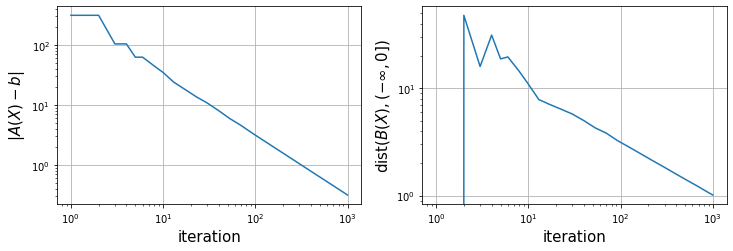

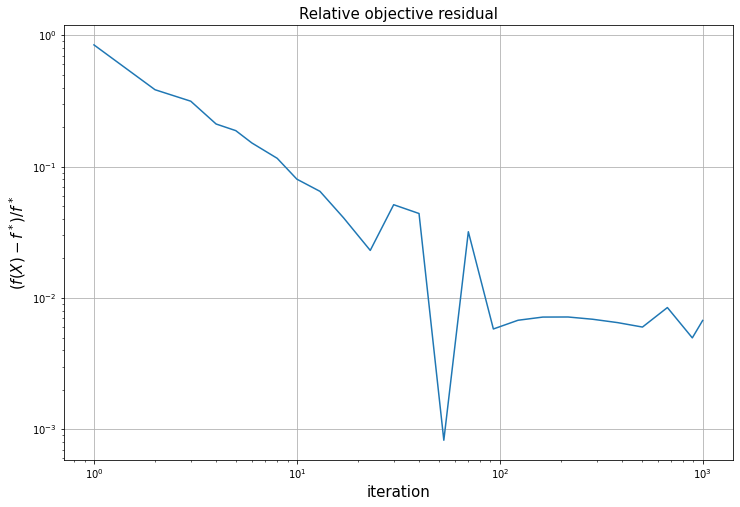

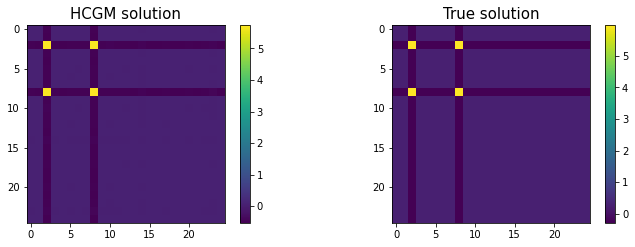

In [7]:
plot_func(iter_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, X_HCGM, X_true)

In [6]:
dataset, Problem, C, p, opt_val, X_true, nchoosek_inds =load_data(55)
print("\nDataset = {}. \n".format(dataset))
print("\n f_opt = {}. \n".format(opt_val))

X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(kappa=p, maxit=np.int(1e3), beta0=5e1)

print("\nHCGM finished. Running time: {} seconds.".format(time_HCGM[-1]))

<ipython-input-2-326c931cf1e5>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.int(Problem['d']) # number of data points
<ipython-input-6-ab5633427baf>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP


Dataset = data/55n-insecta-ant-colony1-day37.mat. 


 f_opt = [[308.10185319]]. 

001 | 1.5125e+03| 0.0000e+00| 5.8205e+02|
002 | 1.5125e+03| 1.3310e+02| 1.9402e+02|
003 | 5.0417e+02| 4.4366e+01| 4.9253e+02|
004 | 5.0417e+02| 1.1663e+02| 2.9552e+02|
005 | 3.0250e+02| 6.9981e+01| 4.1517e+02|
006 | 3.0250e+02| 1.9635e+01| 2.9655e+02|
008 | 2.1607e+02| 2.4011e+01| 2.8847e+02|
010 | 1.6806e+02| 3.2361e+01| 3.0771e+02|
013 | 1.1635e+02| 1.3270e+01| 3.6092e+02|
017 | 8.8971e+01| 1.1743e+01| 3.5666e+02|
023 | 6.5761e+01| 7.3646e+00| 3.3511e+02|
030 | 5.2155e+01| 5.2982e+00| 3.0936e+02|
040 | 3.8782e+01| 5.1227e+00| 3.0551e+02|
053 | 2.8538e+01| 4.8480e+00| 3.1909e+02|
070 | 2.1920e+01| 3.4039e+00| 3.0804e+02|
093 | 1.6263e+01| 3.3353e+00| 3.1351e+02|
123 | 1.2297e+01| 2.6361e+00| 3.1193e+02|
163 | 9.2791e+00| 2.3076e+00| 3.1116e+02|
217 | 6.9700e+00| 2.2014e+00| 3.1033e+02|
287 | 5.2700e+00| 1.7741e+00| 3.0968e+02|
381 | 3.9698e+00| 1.5857e+00| 3.0915e+02|
505 | 2.9950e+00| 1.2997e+00| 3.086

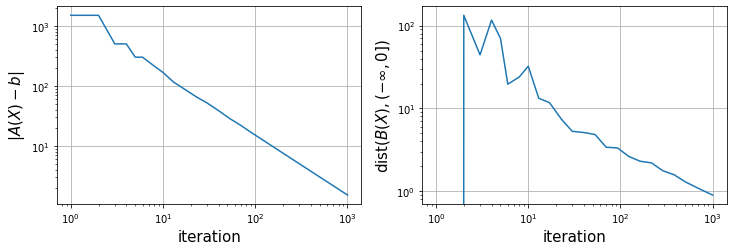

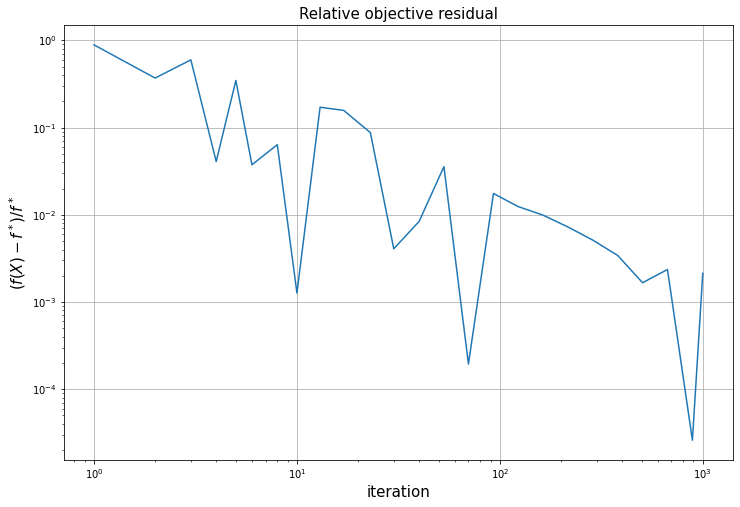

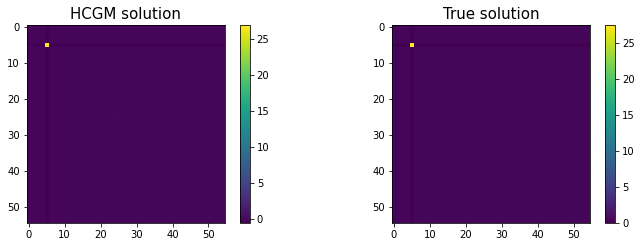

In [7]:
plot_func(iter_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, X_HCGM, X_true)

In [8]:
dataset, Problem, C, p, opt_val, X_true, nchoosek_inds =load_data(102)
print("\nDataset = {}. \n".format(dataset))
print("\n f_opt = {}. \n".format(opt_val))

X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(kappa=p, maxit=np.int(1e3), beta0=5e1)

print("\nHCGM finished. Running time: {} seconds.".format(time_HCGM[-1]))

<ipython-input-2-326c931cf1e5>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = np.int(Problem['d']) # number of data points
<ipython-input-8-5d3dc759ecb2>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP


Dataset = data/102n-insecta-ant-colony4-day10.mat. 


 f_opt = [[669.56459553]]. 

001 | 5.2020e+03| 0.0000e+00| 1.3078e+03|
002 | 5.2020e+03| 1.4711e+02| 4.3593e+02|
003 | 1.7340e+03| 4.9038e+01| 1.2256e+03|
004 | 1.7340e+03| 3.1488e+02| 7.3536e+02|
005 | 1.0404e+03| 1.8893e+02| 1.1127e+03|
006 | 1.0404e+03| 7.3615e+01| 7.9480e+02|
008 | 7.4314e+02| 9.7239e+01| 8.1120e+02|
010 | 5.7800e+02| 7.3494e+01| 9.4545e+02|
013 | 4.0015e+02| 2.6638e+01| 1.0002e+03|
017 | 3.0600e+02| 1.5553e+01| 8.8891e+02|
023 | 2.2617e+02| 1.2735e+01| 8.2143e+02|
030 | 1.7938e+02| 6.9966e+00| 7.2529e+02|
040 | 1.3338e+02| 4.0708e+00| 7.0069e+02|
053 | 9.8151e+01| 3.6252e+00| 7.1116e+02|
070 | 7.5391e+01| 3.2242e+00| 6.7734e+02|
093 | 5.5935e+01| 2.2292e+00| 6.8704e+02|
123 | 4.2293e+01| 2.3437e+00| 6.8156e+02|
163 | 3.1914e+01| 2.0405e+00| 6.7793e+02|
217 | 2.3972e+01| 1.5803e+00| 6.7504e+02|
287 | 1.8125e+01| 1.3845e+00| 6.7305e+02|
381 | 1.3654e+01| 1.2027e+00| 6.7178e+02|
505 | 1.0301e+01| 1.0463e+00| 6.70

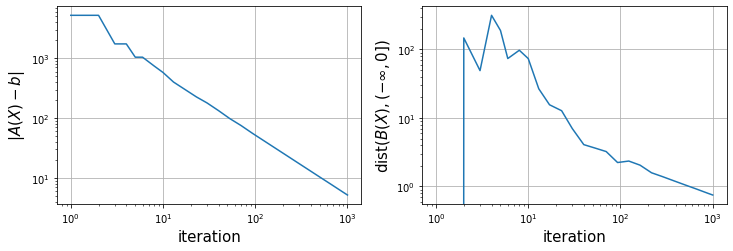

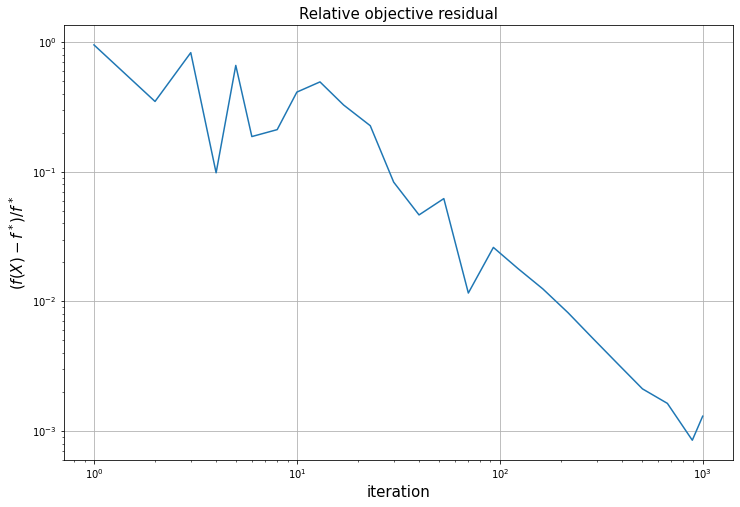

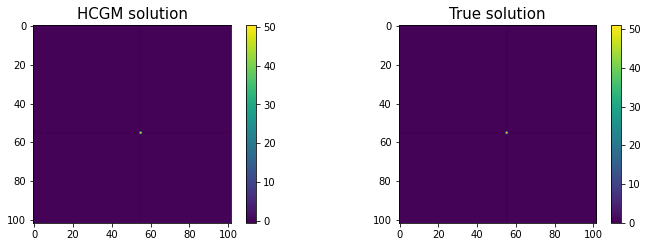

In [9]:
plot_func(iter_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, X_HCGM, X_true)